In [1]:
import pylab as plt
import nilearn
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn import image as image
from nilearn import plotting
from glob import glob
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_contrast_matrix
from nilearn.glm.contrasts import compute_contrast
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.maskers import NiftiSpheresMasker

In [2]:
# Loading events files
events_file_4641 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/sub-4641_events.tsv'
events_4641 = pd.read_table(events_file_4641)
events_4641 = events_4641.rename(columns={'trials.started': 'onset', 'condition': 'trial_type'})

events_file_4643 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/sub-4643_events.tsv'
events_4643 = pd.read_table(events_file_4643)
events_4643 = events_4643.rename(columns={'trials.started': 'onset', 'condition': 'trial_type'})

events_file_4644 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/sub-4644_events.tsv'
events_4644 = pd.read_table(events_file_4644)
events_4644 = events_4644.rename(columns={'trials.started': 'onset', 'condition': 'trial_type'})

In [3]:
# Load movement confounds (rotation, translation in xyz)
confounds_file_4641 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/rucha_olivia/derivatives/sub-4641/ses-1/func/sub-4641_ses-1_task-words_run-1_desc-confounds_timeseries.tsv'
confounds_4641 = pd.read_table(confounds_file_4641)
confounds_4641 = confounds_4641[['rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z', 'global_signal',
                 'csf', 'white_matter']]

confounds_file_4643 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/l_nard_ilan/derivatives/sub-4643/func/sub-4643_task-words_run-1_desc-confounds_timeseries.tsv'
confounds_4643 = pd.read_table(confounds_file_4643)
confounds_4643 = confounds_4643[['rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z', 'global_signal',
                 'csf', 'white_matter']]

confounds_file_4644 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/yiling_lenae/derivatives/sub-4644/func/sub-4644_task-words_run-1_desc-confounds_timeseries.tsv'
confounds_4644 = pd.read_table(confounds_file_4644)
confounds_4644 = confounds_4644[['rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z', 'global_signal',
                 'csf', 'white_matter']]

In [4]:
# Loading fMRI images and masks
fmri_file_4641 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/rucha_olivia/derivatives/sub-4641/ses-1/func/sub-4641_ses-1_task-words_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
mask_file_4641 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/rucha_olivia/derivatives/sub-4641/ses-1/func/sub-4641_ses-1_task-words_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
bold_4641 = image.load_img(fmri_file_4641)
mask_4641 = image.load_img(mask_file_4641)

fmri_file_4643 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/l_nard_ilan/derivatives/sub-4643/func/sub-4643_task-words_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
mask_file_4643 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/l_nard_ilan/derivatives/sub-4643/func/sub-4643_task-words_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
bold_4643 = image.load_img(fmri_file_4643)
mask_4643 = image.load_img(mask_file_4643)

fmri_file_4644 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/yiling_lenae/derivatives/sub-4644/func/sub-4644_task-words_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
mask_file_4644 = '/Users/howardchiu/Documents/GitHub/EDUC464/finalproject/yiling_lenae/derivatives/sub-4644/func/sub-4644_task-words_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
bold_4644 = image.load_img(fmri_file_4644)
mask_4644 = image.load_img(mask_file_4644)

In [5]:
# Define TR
t_r = 1.25

# Detrend + Standardize the data + Mask
func_ds_4641 = image.clean_img(bold_4641, detrend=True, standardize=True, t_r=t_r)
func_ds_4643 = image.clean_img(bold_4643, detrend=True, standardize=True, t_r=t_r)
func_ds_4644 = image.clean_img(bold_4644, detrend=True, standardize=True, t_r=t_r)

/Users/howardchiu/miniconda3/envs/educ464/lib/python3.11/site-packages/nilearn/image/image.py:1272: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


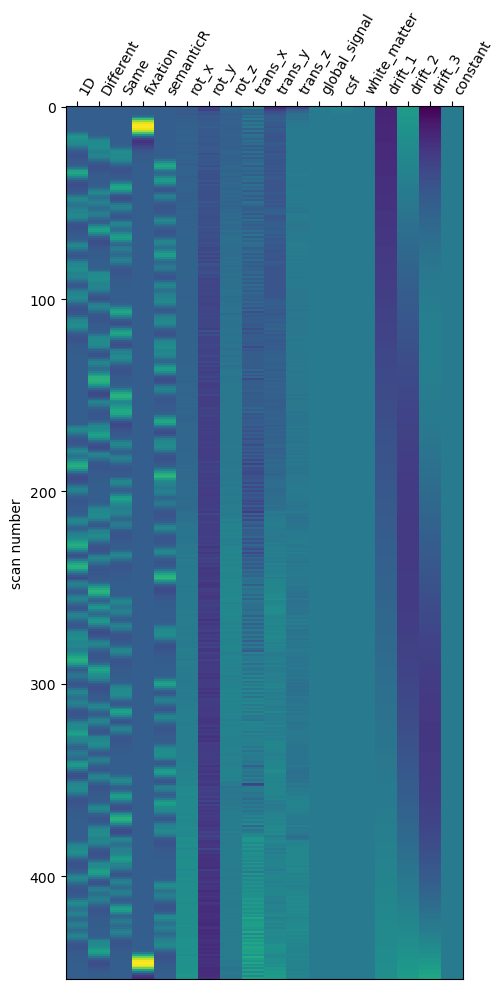

In [6]:
# Fit first level model with SPM HRF -- set signal_scaling to False so predictions are on same scale as observed
first_level_model_hrf_1 = FirstLevelModel(t_r, hrf_model='glover', signal_scaling=False, mask_img=mask_4641, minimize_memory=False, drift_model='polynomial', drift_order=3)
first_level_model_hrf_2 = FirstLevelModel(t_r, hrf_model='glover', signal_scaling=False, mask_img=mask_4643, minimize_memory=False, drift_model='polynomial', drift_order=3)
first_level_model_hrf_3 = FirstLevelModel(t_r, hrf_model='glover', signal_scaling=False, mask_img=mask_4644, minimize_memory=False, drift_model='polynomial', drift_order=3)
# first_level_model_hrf_3 = FirstLevelModel(t_r, slice_time_ref=0.5, hrf_model='glover', signal_scaling=False, mask_img=False, minimize_memory=False, drift_model='polynomial', drift_order=0)

first_level_model_hrf_4641 = first_level_model_hrf_1.fit(func_ds_4641, events=events_4641, confounds=confounds_4641)
first_level_model_hrf_4643 = first_level_model_hrf_2.fit(func_ds_4643, events=events_4643, confounds=confounds_4643)
first_level_model_hrf_4644 = first_level_model_hrf_3.fit(func_ds_4644, events=events_4644, confounds=confounds_4644)

### Plot the design matrix for this new First Level Model
first_level_model_hrf_matrix_4644 = first_level_model_hrf_4644.design_matrices_[0]
plot_design_matrix(first_level_model_hrf_matrix_4644)

plt.show()

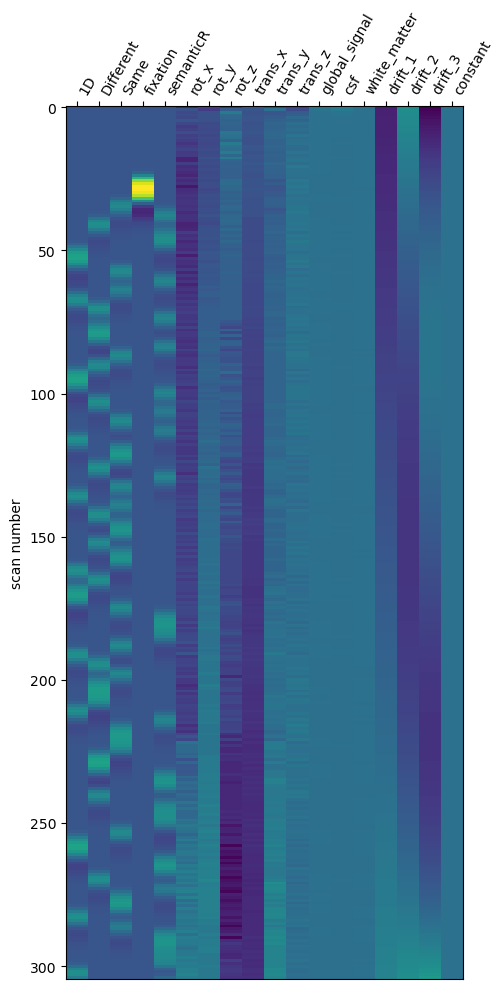

In [7]:
### Plot the design matrix for this new First Level Model
first_level_model_hrf_matrix_4643 = first_level_model_hrf_4643.design_matrices_[0]
plot_design_matrix(first_level_model_hrf_matrix_4643)

plt.show()

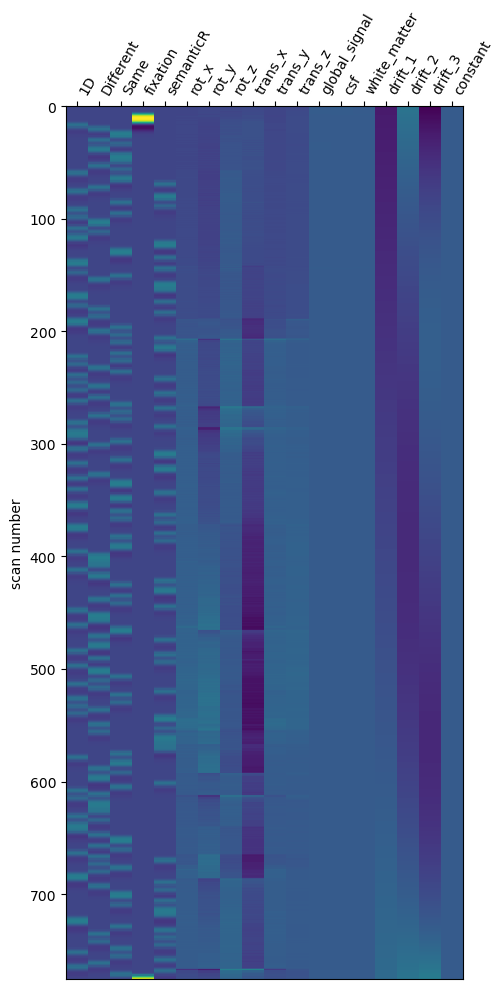

In [8]:
### Plot the design matrix for this new First Level Model
first_level_model_hrf_matrix_4641 = first_level_model_hrf_4641.design_matrices_[0]
plot_design_matrix(first_level_model_hrf_matrix_4641)

plt.show()

In [9]:
# use design matrix to set up contrasts
# contrast_matrix = np.eye(design_matrix.shape[1])
contrast_matrix_4641 = np.eye(first_level_model_hrf_matrix_4641.shape[1])
contrasts_4641 = {
    column: contrast_matrix_4641[i]
    for i, column in enumerate(first_level_model_hrf_matrix_4641.columns)
}

contrast_matrix_4643 = np.eye(first_level_model_hrf_matrix_4643.shape[1])
contrasts_4643 = {
    column: contrast_matrix_4643[i]
    for i, column in enumerate(first_level_model_hrf_matrix_4643.columns)
}

contrast_matrix_4644 = np.eye(first_level_model_hrf_matrix_4644.shape[1])
contrasts_4644 = {
    column: contrast_matrix_4644[i]
    for i, column in enumerate(first_level_model_hrf_matrix_4644.columns)
}

<Axes: label='conditions'>

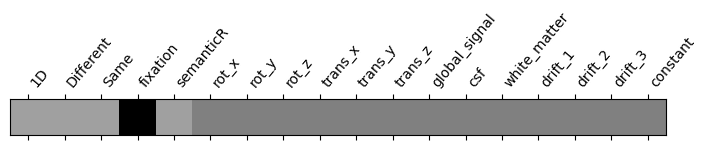

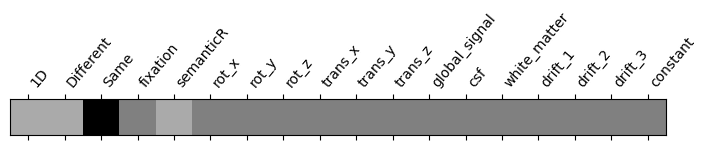

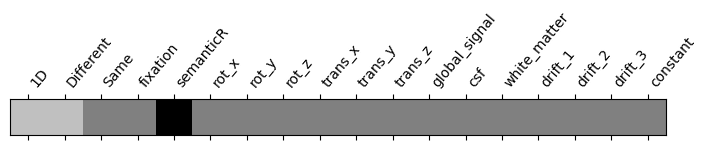

In [10]:
# subtract conditions from one another

allvis_4641 = 0.25*contrasts_4641["Same"]+0.25*contrasts_4641["semanticR"]+0.25*contrasts_4641["1D"]+0.25*contrasts_4641["Different"]-contrasts_4641["fixation"]
repsupp_4641 = -contrasts_4641["Same"]+0.33*contrasts_4641["semanticR"]+0.33*contrasts_4641["1D"]+0.33*contrasts_4641["Different"]
semdist_4641 = -contrasts_4641["semanticR"]+0.5*contrasts_4641["Different"]+0.5*contrasts_4641["1D"]
# iden_minus_sem_4641 = contrasts_4641["Same"]-contrasts_4641["semanticR"]
# iden_minus_ortho_4641 = contrasts_4641["Same"]-contrasts_4641["1D"]
# iden_minus_diff_4641 = contrasts_4641["Same"]-contrasts_4641["Different"]
# sem_minus_ortho_4641 = contrasts_4641["semanticR"]-contrasts_4641["1D"]
# sem_minus_diff_4641 = contrasts_4641["semanticR"]-contrasts_4641["Different"]
# ortho_minus_diff_4641 = contrasts_4641["1D"]-contrasts_4641["Different"]

# plot contrast matrices
plot_contrast_matrix(allvis_4641, first_level_model_hrf_matrix_4641)
plot_contrast_matrix(repsupp_4641, first_level_model_hrf_matrix_4641)
plot_contrast_matrix(semdist_4641, first_level_model_hrf_matrix_4641)
# plot_contrast_matrix(iden_minus_sem_4641, first_level_model_hrf_matrix_4641)
# plot_contrast_matrix(iden_minus_ortho_4641, first_level_model_hrf_matrix_4641)
# plot_contrast_matrix(iden_minus_diff_4641, first_level_model_hrf_matrix_4641)
# plot_contrast_matrix(sem_minus_ortho_4641, first_level_model_hrf_matrix_4641)
# plot_contrast_matrix(sem_minus_diff_4641, first_level_model_hrf_matrix_4641)
# plot_contrast_matrix(ortho_minus_diff_4641, first_level_model_hrf_matrix_4641)

<Axes: label='conditions'>

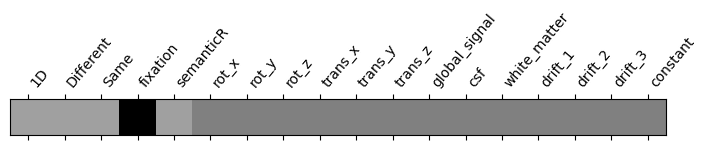

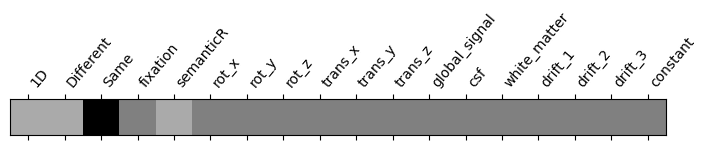

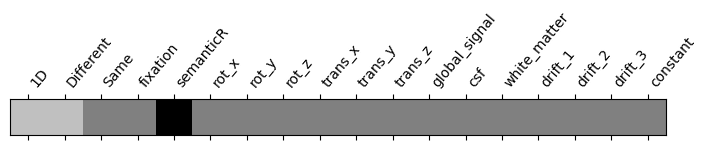

In [11]:
allvis_4643 = 0.25*contrasts_4643["Same"]+0.25*contrasts_4643["semanticR"]+0.25*contrasts_4643["1D"]+0.25*contrasts_4643["Different"]-contrasts_4643["fixation"]
repsupp_4643 = -contrasts_4643["Same"]+0.33*contrasts_4643["semanticR"]+0.33*contrasts_4643["1D"]+0.33*contrasts_4643["Different"]
semdist_4643 = -contrasts_4643["semanticR"]+0.5*contrasts_4643["Different"]+0.5*contrasts_4643["1D"]
# iden_minus_sem_4643 = contrasts_4643["Same"]-contrasts_4643["semanticR"]
# iden_minus_ortho_4643 = contrasts_4643["Same"]-contrasts_4643["1D"]
# iden_minus_diff_4643 = contrasts_4643["Same"]-contrasts_4643["Different"]
# sem_minus_ortho_4643 = contrasts_4643["semanticR"]-contrasts_4643["1D"]
# sem_minus_diff_4643 = contrasts_4643["semanticR"]-contrasts_4643["Different"]
# ortho_minus_diff_4643 = contrasts_4643["1D"]-contrasts_4643["Different"]

# plot contrast matrices
plot_contrast_matrix(allvis_4643, first_level_model_hrf_matrix_4643)
plot_contrast_matrix(repsupp_4643, first_level_model_hrf_matrix_4643)
plot_contrast_matrix(semdist_4643, first_level_model_hrf_matrix_4643)
# plot_contrast_matrix(iden_minus_sem_4643, first_level_model_hrf_matrix_4643)
# plot_contrast_matrix(iden_minus_ortho_4643, first_level_model_hrf_matrix_4643)
# plot_contrast_matrix(iden_minus_diff_4643, first_level_model_hrf_matrix_4643)
# plot_contrast_matrix(sem_minus_ortho_4643, first_level_model_hrf_matrix_4643)
# plot_contrast_matrix(sem_minus_diff_4643, first_level_model_hrf_matrix_4643)
# plot_contrast_matrix(ortho_minus_diff_4643, first_level_model_hrf_matrix_4643)

<Axes: label='conditions'>

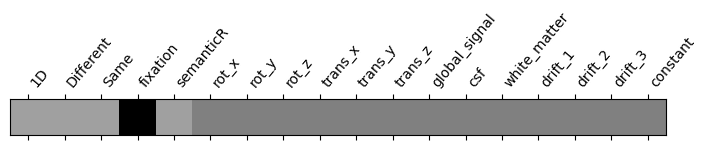

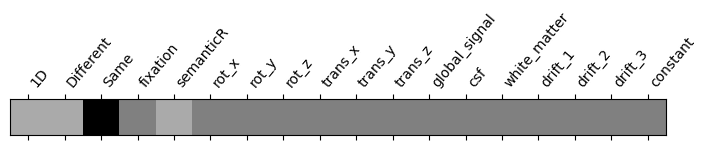

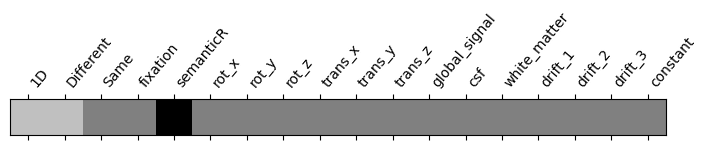

In [12]:
allvis_4644 = 0.25*contrasts_4644["Same"]+0.25*contrasts_4644["semanticR"]+0.25*contrasts_4644["1D"]+0.25*contrasts_4644["Different"]-contrasts_4644["fixation"]
repsupp_4644 = -contrasts_4644["Same"]+0.33*contrasts_4644["semanticR"]+0.33*contrasts_4644["1D"]+0.33*contrasts_4644["Different"]
semdist_4644 = -contrasts_4644["semanticR"]+0.5*contrasts_4644["Different"]+0.5*contrasts_4644["1D"]
# iden_minus_sem_4644 = contrasts_4644["Same"]-contrasts_4644["semanticR"]
# iden_minus_ortho_4644 = contrasts_4644["Same"]-contrasts_4644["1D"]
# iden_minus_diff_4644 = contrasts_4644["Same"]-contrasts_4644["Different"]
# sem_minus_ortho_4644 = contrasts_4644["semanticR"]-contrasts_4644["1D"]
# sem_minus_diff_4644 = contrasts_4644["semanticR"]-contrasts_4644["Different"]
# ortho_minus_diff_4644 = contrasts_4644["1D"]-contrasts_4644["Different"]

# plot contrast matrices
plot_contrast_matrix(allvis_4644, first_level_model_hrf_matrix_4644)
plot_contrast_matrix(repsupp_4644, first_level_model_hrf_matrix_4644)
plot_contrast_matrix(semdist_4644, first_level_model_hrf_matrix_4644)
# plot_contrast_matrix(iden_minus_sem_4644, first_level_model_hrf_matrix_4644)
# plot_contrast_matrix(iden_minus_ortho_4644, first_level_model_hrf_matrix_4644)
# plot_contrast_matrix(iden_minus_diff_4644, first_level_model_hrf_matrix_4644)
# plot_contrast_matrix(sem_minus_ortho_4644, first_level_model_hrf_matrix_4644)
# plot_contrast_matrix(sem_minus_diff_4644, first_level_model_hrf_matrix_4644)
# plot_contrast_matrix(ortho_minus_diff_4644, first_level_model_hrf_matrix_4644)

In [13]:
# compute the statistical map using our contrast
z_allvis_map_4641 = first_level_model_hrf_4641.compute_contrast(
    allvis_4641, output_type="z_score")

z_repsupp_map_4641 = first_level_model_hrf_4641.compute_contrast(
    repsupp_4641, output_type="z_score")

z_semdist_map_4641 = first_level_model_hrf_4641.compute_contrast(
    semdist_4641, output_type="z_score")
    
# z_iden_minus_sem_map_4641 = first_level_model_hrf_4641.compute_contrast(
#     iden_minus_sem_4641, output_type="z_score")

# z_iden_minus_ortho_map_4641 = first_level_model_hrf_4641.compute_contrast(
#     iden_minus_ortho_4641, output_type="z_score")

# z_iden_minus_diff_map_4641 = first_level_model_hrf_4641.compute_contrast(
#     iden_minus_diff_4641, output_type="z_score")

# z_sem_minus_ortho_map_4641 = first_level_model_hrf_4641.compute_contrast(
#     sem_minus_ortho_4641, output_type="z_score")

# z_sem_minus_diff_map_4641 = first_level_model_hrf_4641.compute_contrast(
#     sem_minus_diff_4641, output_type="z_score")

# z_ortho_minus_diff_map_4641 = first_level_model_hrf_4641.compute_contrast(
#     ortho_minus_diff_4641, output_type="z_score")

/Users/howardchiu/miniconda3/envs/educ464/lib/python3.11/site-packages/nilearn/glm/_utils.py:346: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


In [14]:
z_allvis_map_4643 = first_level_model_hrf_4643.compute_contrast(
    allvis_4643, output_type="z_score")

z_repsupp_map_4643 = first_level_model_hrf_4643.compute_contrast(
    repsupp_4643, output_type="z_score")

z_semdist_map_4643 = first_level_model_hrf_4643.compute_contrast(
    semdist_4643, output_type="z_score")

# z_iden_minus_sem_map_4643 = first_level_model_hrf_4643.compute_contrast(
#     iden_minus_sem_4643, output_type="z_score")

# z_iden_minus_ortho_map_4643 = first_level_model_hrf_4643.compute_contrast(
#     iden_minus_ortho_4643, output_type="z_score")

# z_iden_minus_diff_map_4643 = first_level_model_hrf_4643.compute_contrast(
#     iden_minus_diff_4643, output_type="z_score")

# z_sem_minus_ortho_map_4643 = first_level_model_hrf_4643.compute_contrast(
#     sem_minus_ortho_4643, output_type="z_score")

# z_sem_minus_diff_map_4643 = first_level_model_hrf_4643.compute_contrast(
#     sem_minus_diff_4643, output_type="z_score")

# z_ortho_minus_diff_map_4643 = first_level_model_hrf_4643.compute_contrast(
#     ortho_minus_diff_4643, output_type="z_score")

In [15]:
z_allvis_map_4644 = first_level_model_hrf_4644.compute_contrast(
    allvis_4644, output_type="z_score")

z_repsupp_map_4644 = first_level_model_hrf_4644.compute_contrast(
    repsupp_4644, output_type="z_score")

z_semdist_map_4644 = first_level_model_hrf_4644.compute_contrast(
    semdist_4644, output_type="z_score")

# z_iden_minus_sem_map_4644 = first_level_model_hrf_4644.compute_contrast(
#     iden_minus_sem_4644, output_type="z_score")

# z_iden_minus_ortho_map_4644 = first_level_model_hrf_4644.compute_contrast(
#     iden_minus_ortho_4644, output_type="z_score")

# z_iden_minus_diff_map_4644 = first_level_model_hrf_4644.compute_contrast(
#     iden_minus_diff_4644, output_type="z_score")

# z_sem_minus_ortho_map_4644 = first_level_model_hrf_4644.compute_contrast(
#     sem_minus_ortho_4644, output_type="z_score")

# z_sem_minus_diff_map_4644 = first_level_model_hrf_4644.compute_contrast(
#     sem_minus_diff_4644, output_type="z_score")

# z_ortho_minus_diff_map_4644 = first_level_model_hrf_4644.compute_contrast(
#     ortho_minus_diff_4644, output_type="z_score")

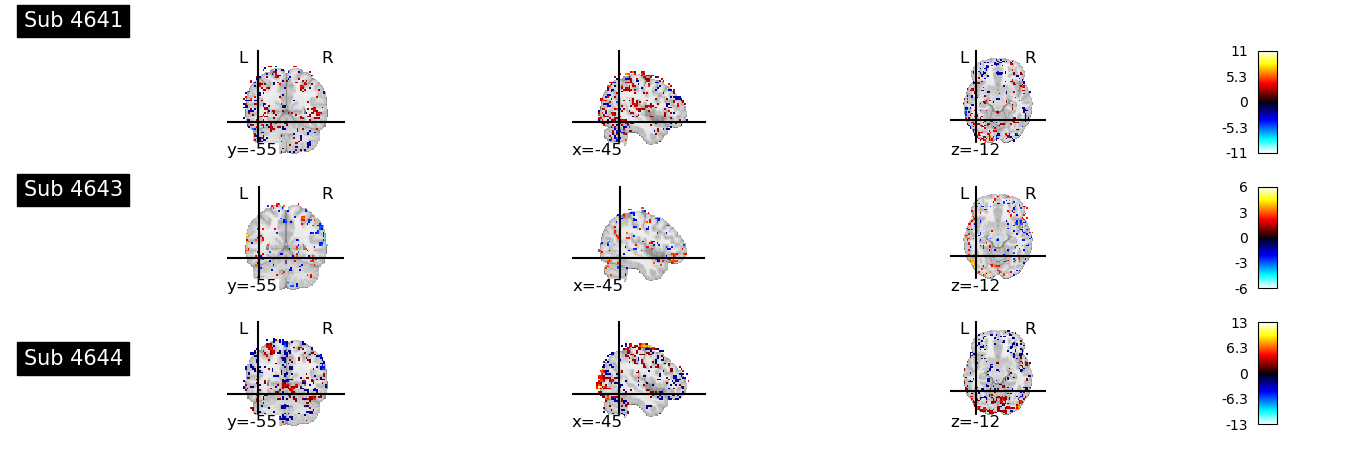

In [16]:
sigthresh=2

# Create subplots using subplots() function
fig, axs = plt.subplots(3, 1, figsize=(15, 5))  # 1 row, 3 columns

# Grab clusters of voxels that exceed a specific z-threshold and cluster size
allvis_img_4641 = image.threshold_img(z_allvis_map_4641, threshold=sigthresh)
allvis_img_4643 = image.threshold_img(z_allvis_map_4643, threshold=sigthresh)
allvis_img_4644 = image.threshold_img(z_allvis_map_4644, threshold=sigthresh)

plotting.plot_stat_map(allvis_img_4641, title='Sub 4641', axes=axs[0], display_mode='ortho', cut_coords=(-45,-55,-12))
plotting.plot_stat_map(allvis_img_4643, title='Sub 4643', axes=axs[1], display_mode='ortho', cut_coords=(-45,-55,-12))
plotting.plot_stat_map(allvis_img_4644, title='Sub 4644', axes=axs[2], display_mode='ortho', cut_coords=(-45,-55,-12))

# −44, −67, −4 in MNI coordinates
# MNI −42, −57, −15
#-45, -57, -12

# Manually adjust subplot spacing
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

# Display the plot
plt.show()

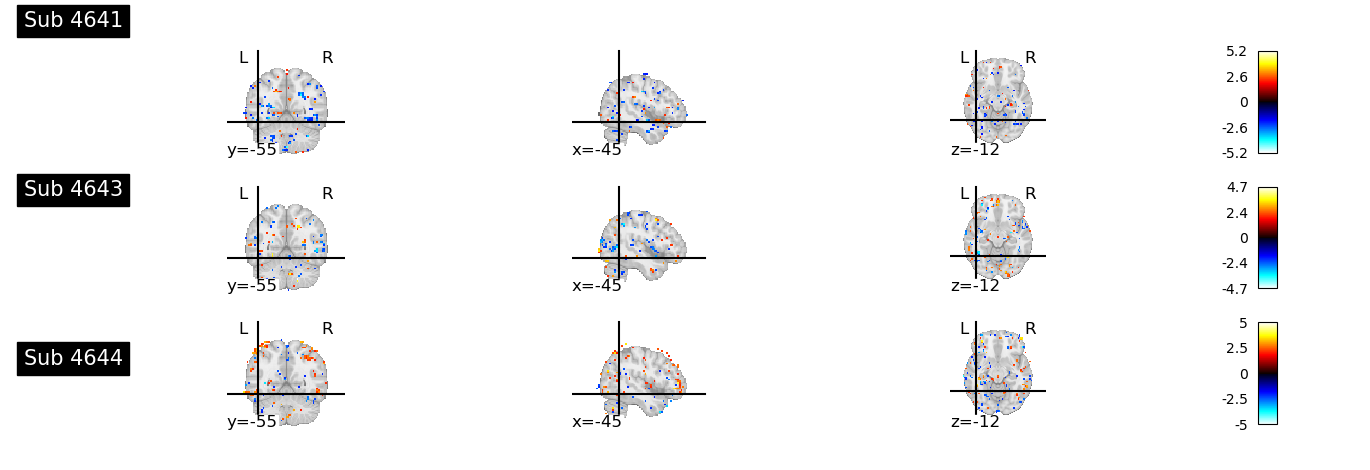

In [17]:
# Create subplots using subplots() function
fig, axs = plt.subplots(3, 1, figsize=(15, 5))  # 1 row, 3 columns

# Grab clusters of voxels that exceed a specific z-threshold and cluster size
repsupp_img_4641 = image.threshold_img(z_repsupp_map_4641, threshold=sigthresh)
repsupp_img_4643 = image.threshold_img(z_repsupp_map_4643, threshold=sigthresh)
repsupp_img_4644 = image.threshold_img(z_repsupp_map_4644, threshold=sigthresh)
#this is wrong, iden minus anything should be blue

plotting.plot_stat_map(repsupp_img_4641, title='Sub 4641', axes=axs[0], display_mode='ortho', cut_coords=(-45,-55,-12))
plotting.plot_stat_map(repsupp_img_4643, title='Sub 4643', axes=axs[1], display_mode='ortho', cut_coords=(-45,-55,-12))
plotting.plot_stat_map(repsupp_img_4644, title='Sub 4644', axes=axs[2], display_mode='ortho', cut_coords=(-45,-55,-12))

# Manually adjust subplot spacing
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

# Display the plot
plt.show()

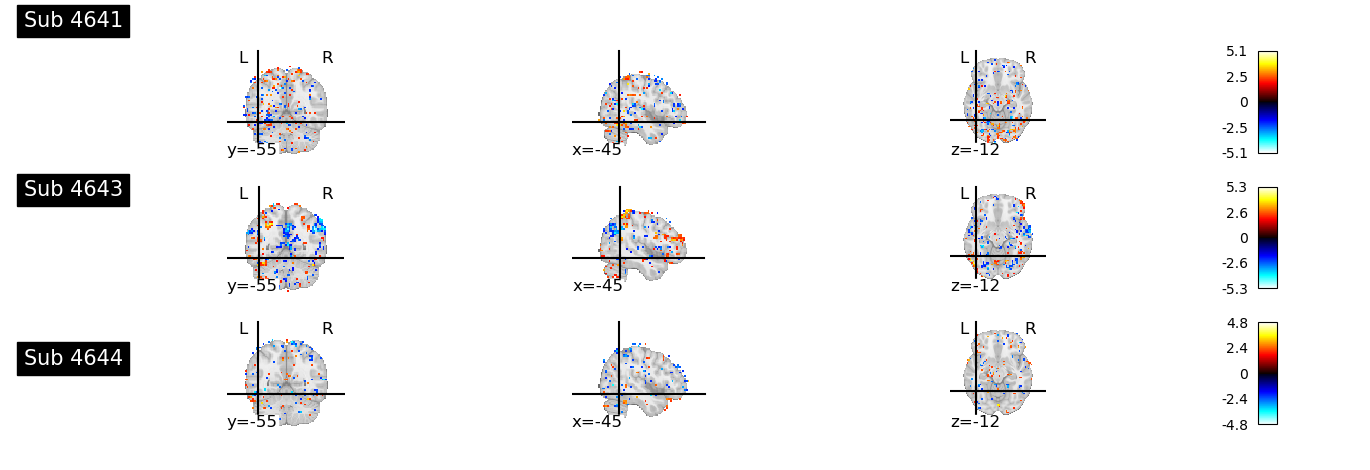

In [18]:
# Create subplots using subplots() function
fig, axs = plt.subplots(3, 1, figsize=(15, 5))  # 1 row, 3 columns

# Grab clusters of voxels that exceed a specific z-threshold and cluster size
semdist_img_4641 = image.threshold_img(z_semdist_map_4641, threshold=sigthresh)
semdist_img_4643 = image.threshold_img(z_semdist_map_4643, threshold=sigthresh)
semdist_img_4644 = image.threshold_img(z_semdist_map_4644, threshold=sigthresh)

plotting.plot_stat_map(semdist_img_4641, title='Sub 4641', axes=axs[0], display_mode='ortho', cut_coords=(-45,-55,-12))
plotting.plot_stat_map(semdist_img_4643, title='Sub 4643', axes=axs[1], display_mode='ortho', cut_coords=(-45,-55,-12))
plotting.plot_stat_map(semdist_img_4644, title='Sub 4644', axes=axs[2], display_mode='ortho', cut_coords=(-45,-55,-12))

# Manually adjust subplot spacing
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

# Display the plot
plt.show()

In [19]:
# # Create subplots using subplots() function
# fig, axs = plt.subplots(3, 1, figsize=(15, 5))  # 1 row, 3 columns

# # Grab clusters of voxels that exceed a specific z-threshold and cluster size
# idensem_img_4641 = image.threshold_img(z_iden_minus_sem_map_4641, threshold=2.33, cluster_threshold=10)
# idensem_img_4643 = image.threshold_img(z_iden_minus_sem_map_4643, threshold=2.33, cluster_threshold=10)
# idensem_img_4644 = image.threshold_img(z_iden_minus_sem_map_4644, threshold=2.33, cluster_threshold=10)
# #this is wrong, iden minus anything should be blue

# plotting.plot_stat_map(idensem_img_4641, title='Sub 4641', axes=axs[0], display_mode='ortho')
# plotting.plot_stat_map(idensem_img_4643, title='Sub 4643', axes=axs[1], display_mode='ortho')
# plotting.plot_stat_map(idensem_img_4644, title='Sub 4644', axes=axs[2], display_mode='ortho')

# # Manually adjust subplot spacing
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

# # Display the plot
# plt.show()

In [20]:
# # Create subplots using subplots() function
# fig, axs = plt.subplots(3, 1, figsize=(15, 5))  # 1 row, 3 columns

# # Grab clusters of voxels that exceed a specific z-threshold and cluster size
# idenortho_img_4641 = image.threshold_img(z_iden_minus_ortho_map_4641, threshold=2.33, cluster_threshold=10)
# idenortho_img_4643 = image.threshold_img(z_iden_minus_ortho_map_4643, threshold=2.33, cluster_threshold=10)
# idenortho_img_4644 = image.threshold_img(z_iden_minus_ortho_map_4644, threshold=2.33, cluster_threshold=10)

# plotting.plot_stat_map(idenortho_img_4641, title='Sub 4641', axes=axs[0], display_mode='ortho')
# plotting.plot_stat_map(idenortho_img_4643, title='Sub 4643', axes=axs[1], display_mode='ortho')
# plotting.plot_stat_map(idenortho_img_4644, title='Sub 4644', axes=axs[2], display_mode='ortho')

# # Manually adjust subplot spacing
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

# # Display the plot
# plt.show()

In [21]:
# # Create subplots using subplots() function
# fig, axs = plt.subplots(3, 1, figsize=(15, 5))  # 1 row, 3 columns

# # Grab clusters of voxels that exceed a specific z-threshold and cluster size
# idendiff_img_4641 = image.threshold_img(z_iden_minus_diff_map_4641, threshold=sigthresh, cluster_threshold=20)
# idendiff_img_4643 = image.threshold_img(z_iden_minus_diff_map_4643, threshold=sigthresh, cluster_threshold=20)
# idendiff_img_4644 = image.threshold_img(z_iden_minus_diff_map_4644, threshold=sigthresh, cluster_threshold=20)

# plotting.plot_stat_map(idendiff_img_4641, title='Sub 4641', axes=axs[0], display_mode='ortho')
# plotting.plot_stat_map(idendiff_img_4643, title='Sub 4643', axes=axs[1], display_mode='ortho')
# plotting.plot_stat_map(idendiff_img_4644, title='Sub 4644', axes=axs[2], display_mode='ortho')

# # Manually adjust subplot spacing
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

# # Display the plot
# plt.show()

In [22]:
# # Create subplots using subplots() function
# fig, axs = plt.subplots(3, 1, figsize=(15, 5))  # 1 row, 3 columns

# # Grab clusters of voxels that exceed a specific z-threshold and cluster size
# semortho_img_4641 = image.threshold_img(z_sem_minus_ortho_map_4641, threshold=sigthresh, cluster_threshold=20)
# semortho_img_4643 = image.threshold_img(z_sem_minus_ortho_map_4643, threshold=sigthresh, cluster_threshold=20)
# semortho_img_4644 = image.threshold_img(z_sem_minus_ortho_map_4644, threshold=sigthresh, cluster_threshold=20)

# plotting.plot_stat_map(semortho_img_4641, title='Sub 4641', axes=axs[0], display_mode='ortho')
# plotting.plot_stat_map(semortho_img_4643, title='Sub 4643', axes=axs[1], display_mode='ortho')
# plotting.plot_stat_map(semortho_img_4644, title='Sub 4644', axes=axs[2], display_mode='ortho')

# # Manually adjust subplot spacing
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

# # Display the plot
# plt.show()

In [23]:
# # Create subplots using subplots() function
# fig, axs = plt.subplots(3, 1, figsize=(15, 5))  # 1 row, 3 columns

# # Grab clusters of voxels that exceed a specific z-threshold and cluster size
# semdiff_img_4641 = image.threshold_img(z_sem_minus_diff_map_4641, threshold=sigthresh, cluster_threshold=20)
# semdiff_img_4643 = image.threshold_img(z_sem_minus_diff_map_4643, threshold=sigthresh, cluster_threshold=20)
# semdiff_img_4644 = image.threshold_img(z_sem_minus_diff_map_4644, threshold=sigthresh, cluster_threshold=20)

# plotting.plot_stat_map(semdiff_img_4641, title='Sub 4641', axes=axs[0], display_mode='ortho')
# plotting.plot_stat_map(semdiff_img_4643, title='Sub 4643', axes=axs[1], display_mode='ortho')
# plotting.plot_stat_map(semdiff_img_4644, title='Sub 4644', axes=axs[2], display_mode='ortho')

# # Manually adjust subplot spacing
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

# # Display the plot
# plt.show()

In [24]:
# # Create subplots using subplots() function
# fig, axs = plt.subplots(3, 1, figsize=(15, 5))  # 1 row, 3 columns

# # Grab clusters of voxels that exceed a specific z-threshold and cluster size
# orthodiff_img_4641 = image.threshold_img(z_ortho_minus_diff_map_4641, threshold=sigthresh, cluster_threshold=20)
# orthodiff_img_4643 = image.threshold_img(z_ortho_minus_diff_map_4643, threshold=sigthresh, cluster_threshold=20)
# orthodiff_img_4644 = image.threshold_img(z_ortho_minus_diff_map_4644, threshold=sigthresh, cluster_threshold=20)

# plotting.plot_stat_map(orthodiff_img_4641, title='Sub 4641', axes=axs[0], display_mode='ortho')
# plotting.plot_stat_map(orthodiff_img_4643, title='Sub 4643', axes=axs[1], display_mode='ortho')
# plotting.plot_stat_map(orthodiff_img_4644, title='Sub 4644', axes=axs[2], display_mode='ortho')

# # Manually adjust subplot spacing
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

# # Display the plot
# plt.show()

In [25]:
#iden minus diff condition represents lowest (highest repetition suppression) and highest limits of activation
#ortho minus diff condition should have no contrast since there are no pseudowords in this experiment - both conditions here have two different words that should be represented distinctly in VWFA

In [26]:
# Assuming you have a list of first-level Nifti image objects
first_level_data = [first_level_model_hrf_4641, first_level_model_hrf_4643, first_level_model_hrf_4644]  # Replace with your Nifti image objects
# , first_level_model_hrf_4644


# Create a second-level model
second_level_model = SecondLevelModel()

# Fit the second-level model using the first-level Nifti image objects
second_level_model.fit(first_level_data)

# You can then access the results of the second-level analysis
z_allvis_map = second_level_model.compute_contrast(first_level_contrast=allvis_4641, output_type='z_score')
z_repsupp_map = second_level_model.compute_contrast(first_level_contrast=repsupp_4641, output_type='z_score')
z_semdist_map = second_level_model.compute_contrast(first_level_contrast=semdist_4641, output_type='z_score')
z_iden_minus_sem_map = second_level_model.compute_contrast(first_level_contrast=iden_minus_sem_4641, output_type='z_score')
z_iden_minus_ortho_map = second_level_model.compute_contrast(first_level_contrast=iden_minus_sem_4641, output_type='z_score')
z_iden_minus_diff_map = second_level_model.compute_contrast(first_level_contrast=iden_minus_sem_4641, output_type='z_score')
z_sem_minus_ortho_map = second_level_model.compute_contrast(first_level_contrast=iden_minus_sem_4641, output_type='z_score')
z_sem_minus_diff_map = second_level_model.compute_contrast(first_level_contrast=iden_minus_sem_4641, output_type='z_score')
z_ortho_minus_diff_map = second_level_model.compute_contrast(first_level_contrast=iden_minus_sem_4641, output_type='z_score')

/Users/howardchiu/miniconda3/envs/educ464/lib/python3.11/site-packages/nilearn/glm/_utils.py:346: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/Users/howardchiu/miniconda3/envs/educ464/lib/python3.11/site-packages/nilearn/glm/_utils.py:346: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


NameError: name 'iden_minus_sem_4641' is not defined

In [ ]:
thresholded_map, threshold = threshold_stats_img(z_allvis_map, alpha=0.01, height_control="fpr")

plotting.plot_stat_map(
    thresholded_map,
    colorbar=True,
    cut_coords=(-45,-57,-12)
 )

# plotting.plot_stat_map(
#    z_iden_minus_sem_map,
#    colorbar=True
# )

plt.show()

In [ ]:
thresholded_map, threshold = threshold_stats_img(z_repsupp_map, alpha=0.01, height_control="fpr")

plotting.plot_stat_map(
    thresholded_map,
    colorbar=True,
    cut_coords=(-45,-57,-12)
 )

# plotting.plot_stat_map(
#    z_iden_minus_sem_map,
#    colorbar=True
# )

plt.show()

In [ ]:
thresholded_map, threshold = threshold_stats_img(z_semdist_map, alpha=0.01, height_control="fpr")

plotting.plot_stat_map(
    thresholded_map,
    colorbar=True,
    cut_coords=(-45,-57,-12)
 )

# plotting.plot_stat_map(
#    z_iden_minus_sem_map,
#    colorbar=True
# )

plt.show()

In [ ]:
# grab our design matrix columns from the non-HRF model for our two conditions and flag whether 
# or not they are not 0 in a given row (meaning this condition was being 
# presented during the acquisition of that particular volume)

# mask_cols_4641 = first_level_model_hrf_matrix_4641[['1D', 'Different', 'Same', 'fixation', 'semanticR']]!=0
# mask_cols_4643 = first_level_model_hrf_matrix_4643[['1D', 'Different', 'Same', 'fixation', 'semanticR']]!=0
# mask_cols_4644 = first_level_model_hrf_matrix_4644[['1D', 'Different', 'Same', 'fixation', 'semanticR']]!=0

# generate a mask based on whether audio_computation or visual_computation was being presented
# condition_mask_4641 = np.array((mask_cols_4641['1D']==True)|(mask_cols_4641['Different']==True)|(mask_cols_4641['Same']==True)|(mask_cols_4641['fixation']==True)|(mask_cols_4641['semanticR']==True))
# condition_mask_4643 = np.array((mask_cols_4643['1D']==True)|(mask_cols_4643['Different']==True)|(mask_cols_4643['Same']==True)|(mask_cols_4643['fixation']==True)|(mask_cols_4643['semanticR']==True))
# condition_mask_4644 = np.array((mask_cols_4644['1D']==True)|(mask_cols_4644['Different']==True)|(mask_cols_4644['Same']==True)|(mask_cols_4644['fixation']==True)|(mask_cols_4644['semanticR']==True))

In [ ]:
# # generate masks
# samecond_mask_4641 = np.array((mask_cols_4641['Same']==True))
# cond1D_mask_4641 = np.array((mask_cols_4641['1D']==True))
# diffcond_mask_4641 = np.array((mask_cols_4641['Different']==True))
# semanticRcond_mask_4641 = np.array((mask_cols_4641['semanticR']==True))
# fixcond_mask_4641 = np.array((mask_cols_4641['fixation']==True))

# # generate masks
# samecond_mask_4643 = np.array((mask_cols_4643['Same']==True))
# cond1D_mask_4643 = np.array((mask_cols_4643['1D']==True))
# diffcond_mask_4643 = np.array((mask_cols_4643['Different']==True))
# semanticRcond_mask_4643 = np.array((mask_cols_4643['semanticR']==True))
# fixcond_mask_4643 = np.array((mask_cols_4643['fixation']==True))

# # generate masks
# samecond_mask_4644 = np.array((mask_cols_4644['Same']==True))
# cond1D_mask_4644 = np.array((mask_cols_4644['1D']==True))
# diffcond_mask_4644 = np.array((mask_cols_4644['Different']==True))
# semanticRcond_mask_4644 = np.array((mask_cols_4644['semanticR']==True))
# fixcond_mask_4644 = np.array((mask_cols_4644['fixation']==True))

# # use the masks to get the time series for the two conditions
# func_ds_same_4641 = image.index_img(func_ds_4641, samecond_mask_4641)
# func_ds_1D_4641 = image.index_img(func_ds_4641, cond1D_mask_4641)
# func_ds_diff_4641 = image.index_img(func_ds_4641, diffcond_mask_4641)
# func_ds_semanticR_4641 = image.index_img(func_ds_4641, semanticRcond_mask_4641)
# func_ds_fix_4641 = image.index_img(func_ds_4641, fixcond_mask_4641)

# # use the masks to get the time series for the two conditions
# func_ds_same_4643 = image.index_img(func_ds_4643, samecond_mask_4643)
# func_ds_1D_4643 = image.index_img(func_ds_4643, cond1D_mask_4643)
# func_ds_diff_4643 = image.index_img(func_ds_4643, diffcond_mask_4643)
# func_ds_semanticR_4643 = image.index_img(func_ds_4643, semanticRcond_mask_4643)
# func_ds_fix_4643 = image.index_img(func_ds_4643, fixcond_mask_4643)

# # use the masks to get the time series for the two conditions
# func_ds_same_4644 = image.index_img(func_ds_4644, samecond_mask_4644)
# func_ds_1D_4644 = image.index_img(func_ds_4644, cond1D_mask_4644)
# func_ds_diff_4644 = image.index_img(func_ds_4644, diffcond_mask_4644)
# func_ds_semanticR_4644 = image.index_img(func_ds_4644, semanticRcond_mask_4644)
# func_ds_fix_4644 = image.index_img(func_ds_4644, fixcond_mask_4644)

In [27]:
vwfa_coords = [(-45, -55, -12)]
labels = [
    "VWFA"
]

masker = NiftiSpheresMasker(
    vwfa_coords,
    radius=8,
    t_r=t_r,
)

In [28]:
vwfa_4641 = masker.fit_transform(func_ds_4641)
vwfa_4643 = masker.fit_transform(func_ds_4643)
vwfa_4644 = masker.fit_transform(func_ds_4644)

In [29]:
# Assuming your DataFrame is named 'first_level_model_hrf_matrix_4641'

# Select the columns you want to compare
column_indices = [0, 1, 2, 3, 4]  # Replace these indices with the columns you want to compare

# Extract the values from the selected columns for all rows
selected_columns_4641 = first_level_model_hrf_matrix_4641.iloc[:, column_indices]

# Find the index of the maximum value column-wise among the selected columns
max_indices_4641 = np.argmax(selected_columns_4641.values, axis=1)

# Assign column names (1 to 5) based on the index of the maximum value
result_matrix_4641 = max_indices_4641

# Reshape the result into a column matrix
result_matrix_4641 = result_matrix_4641.reshape(-1, 1)

# Display the result (if needed)
print(result_matrix_4641)

[[0]
 [0]
 [0]
 [0]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [4]
 [4]
 [4]
 [4]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [2]
 [2]
 [2]
 [2]
 [4]
 [4]
 [4]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [2]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [4]
 [4]
 [4]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [4]
 [4]
 [4]
 [4]
 [0]
 [0]
 [0]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [4]
 [4]
 [4]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [4]
 [4]
 [4]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [2]
 [2]
 [1]


In [ ]:
selected_columns_4641

In [30]:
concatenated_matrix_4641 = np.concatenate((result_matrix_4641, vwfa_4641), axis=1)

concatenated_matrix_4641

array([[ 0.        , 20.2524634 ],
       [ 0.        ,  4.94411549],
       [ 0.        ,  1.47788149],
       ...,
       [ 3.        ,  0.41100818],
       [ 3.        ,  0.40606409],
       [ 3.        ,  0.36727529]])

In [31]:
# Extract the first column (column index 0) which contains values from 0 to 4
first_column_values_4641 = concatenated_matrix_4641[:, 0]

# Get unique values in the first column and count occurrences of each unique value
unique_first_column_values_4641, value_counts_4641 = np.unique(first_column_values_4641, return_counts=True)

# Initialize arrays to store means and standard errors
means_4641 = np.zeros(len(unique_first_column_values_4641))
std_errors_4641 = np.zeros(len(unique_first_column_values_4641))

# Calculate means and standard errors for each unique value in the first column
for i, value in enumerate(unique_first_column_values_4641):
    indices = np.where(first_column_values_4641 == value)[0]  # Get indices for the current unique value
    corresponding_values_4641 = concatenated_matrix_4641[indices, 1]  # Get corresponding values from the second column
    
    # Calculate mean and standard error for the current group
    means_4641[i] = np.mean(corresponding_values_4641)
    std_errors_4641[i] = np.std(corresponding_values_4641, ddof=1) / np.sqrt(len(corresponding_values_4641))

# Create a 5x3 matrix containing unique values, means, and standard errors
result_matrix_4641 = np.column_stack((unique_first_column_values_4641, means_4641, std_errors_4641))

In [32]:
result_matrix_4641

array([[ 0.        ,  0.10006196,  0.11101116],
       [ 1.        , -0.048801  ,  0.0193937 ],
       [ 2.        , -0.02021907,  0.01730877],
       [ 3.        ,  0.07568939,  0.05606991],
       [ 4.        , -0.03694229,  0.0203949 ]])

In [33]:
# Subtract all values in the second column by the value in the second column, fourth row
result_matrix_4641[:, 1] -= result_matrix_4641[3, 1]

# Drop the fourth row from the table
new_result_matrix_4641 = np.delete(result_matrix_4641, 3, axis=0)

print("Modified Result Matrix after subtraction and row deletion:")
print(new_result_matrix_4641)

Modified Result Matrix after subtraction and row deletion:
[[ 0.          0.02437257  0.11101116]
 [ 1.         -0.12449039  0.0193937 ]
 [ 2.         -0.09590846  0.01730877]
 [ 4.         -0.11263168  0.0203949 ]]


In [34]:
# Moving values of the third row to the top row without overwriting
for i in range(len(new_result_matrix_4641[0])):
    temp = new_result_matrix_4641[0][i]  # Store the value of the top row temporarily
    new_result_matrix_4641[0][i] = new_result_matrix_4641[2][i]  # Move the value of the third row to the top row
    new_result_matrix_4641[2][i] = new_result_matrix_4641[1][i]  # Move the value of the second row to the third row
    new_result_matrix_4641[1][i] = temp  # Move the stored value to the second row

# Print the updated table
for row in new_result_matrix_4641:
    print(row)

[ 2.         -0.09590846  0.01730877]
[0.         0.02437257 0.11101116]
[ 1.         -0.12449039  0.0193937 ]
[ 4.         -0.11263168  0.0203949 ]


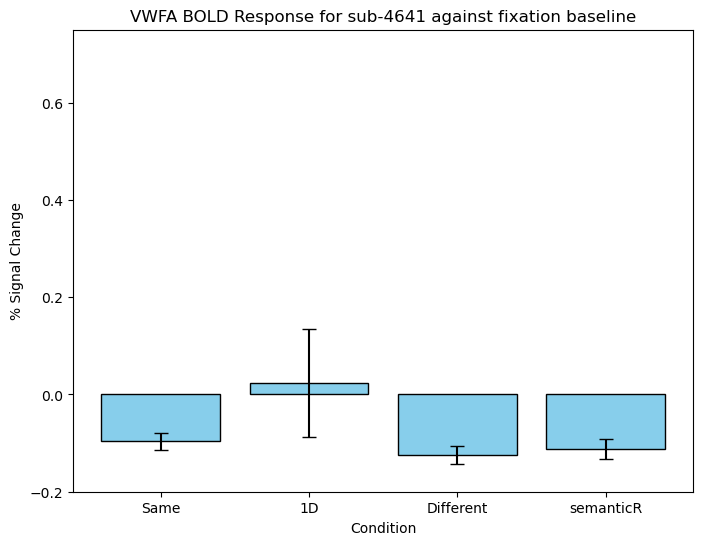

In [35]:
# Rename columns in the new_matrix DataFrame
new_column_names = ['Same', '1D', 'Different', 'semanticR']

# Extracting values for plotting
bar_heights_4641 = new_result_matrix_4641[:, 1]
error_values_4641 = new_result_matrix_4641[:, 2]

# Plotting the bar graph with error bars
plt.figure(figsize=(8, 6))
plt.bar(new_column_names, bar_heights_4641, yerr=error_values_4641, capsize=5, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Condition')
plt.ylabel('% Signal Change')
plt.title('VWFA BOLD Response for sub-4641 against fixation baseline')
plt.ylim(-0.2, 0.75)

# Showing the plot
plt.show()

In [36]:
# Assuming your DataFrame is named 'first_level_model_hrf_matrix_4641'

# Extract the values from the selected columns for all rows
selected_columns_4643 = first_level_model_hrf_matrix_4643.iloc[:, column_indices]

# Find the index of the maximum value column-wise among the selected columns
max_indices_4643 = np.argmax(selected_columns_4643.values, axis=1)

# Assign column names (1 to 5) based on the index of the maximum value
result_matrix_4643 = max_indices_4643

# Reshape the result into a column matrix
result_matrix_4643 = result_matrix_4643.reshape(-1, 1)

concatenated_matrix_4643 = np.concatenate((result_matrix_4643, vwfa_4643), axis=1)

# Extract the first column (column index 0) which contains values from 0 to 4
first_column_values_4643 = concatenated_matrix_4643[:, 0]

# Get unique values in the first column and count occurrences of each unique value
unique_first_column_values_4643, value_counts_4643 = np.unique(first_column_values_4643, return_counts=True)

# Initialize arrays to store means and standard errors
means_4643 = np.zeros(len(unique_first_column_values_4643))
std_errors_4643 = np.zeros(len(unique_first_column_values_4643))

# Calculate means and standard errors for each unique value in the first column
for i, value in enumerate(unique_first_column_values_4643):
    indices = np.where(first_column_values_4643 == value)[0]  # Get indices for the current unique value
    corresponding_values_4643 = concatenated_matrix_4643[indices, 1]  # Get corresponding values from the second column
    
    # Calculate mean and standard error for the current group
    means_4643[i] = np.mean(corresponding_values_4643)
    std_errors_4643[i] = np.std(corresponding_values_4643, ddof=1) / np.sqrt(len(corresponding_values_4643))

# Create a 5x3 matrix containing unique values, means, and standard errors
result_matrix_4643 = np.column_stack((unique_first_column_values_4643, means_4643, std_errors_4643))

In [ ]:
result_matrix_4643

In [37]:
# Subtract all values in the second column by the value in the second column, fourth row
result_matrix_4643[:, 1] -= result_matrix_4643[3, 1]

# Drop the fourth row from the table
new_result_matrix_4643 = np.delete(result_matrix_4643, 3, axis=0)

print("Modified Result Matrix after subtraction and row deletion:")
print(new_result_matrix_4643)

Modified Result Matrix after subtraction and row deletion:
[[0.         0.4981767  0.20540589]
 [1.         0.24660273 0.01671687]
 [2.         0.26280604 0.01629012]
 [4.         0.26581224 0.01909437]]


In [38]:
# Moving values of the third row to the top row without overwriting
for i in range(len(new_result_matrix_4643[0])):
    temp_4643 = new_result_matrix_4643[0][i]  # Store the value of the top row temporarily
    new_result_matrix_4643[0][i] = new_result_matrix_4643[2][i]  # Move the value of the third row to the top row
    new_result_matrix_4643[2][i] = new_result_matrix_4643[1][i]  # Move the value of the second row to the third row
    new_result_matrix_4643[1][i] = temp_4643  # Move the stored value to the second row

# Print the updated table
for row in new_result_matrix_4643:
    print(row)

[2.         0.26280604 0.01629012]
[0.         0.4981767  0.20540589]
[1.         0.24660273 0.01671687]
[4.         0.26581224 0.01909437]


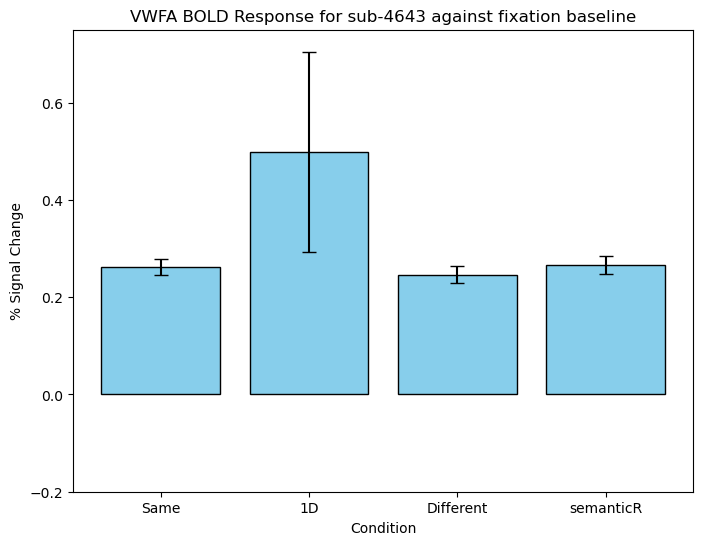

In [39]:
# Extracting values for plotting
bar_heights_4643 = new_result_matrix_4643[:, 1]
error_values_4643 = new_result_matrix_4643[:, 2]

# Plotting the bar graph with error bars
plt.figure(figsize=(8, 6))
plt.bar(new_column_names, bar_heights_4643, yerr=error_values_4643, capsize=5, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Condition')
plt.ylabel('% Signal Change')
plt.title('VWFA BOLD Response for sub-4643 against fixation baseline')
plt.ylim(-0.2, 0.75)

# Showing the plot
plt.show()

In [40]:
# Assuming your DataFrame is named 'first_level_model_hrf_matrix_4641'

# Extract the values from the selected columns for all rows
selected_columns_4644 = first_level_model_hrf_matrix_4644.iloc[:, column_indices]

# Find the index of the maximum value column-wise among the selected columns
max_indices_4644 = np.argmax(selected_columns_4644.values, axis=1)

# Assign column names (1 to 5) based on the index of the maximum value
result_matrix_4644 = max_indices_4644

# Reshape the result into a column matrix
result_matrix_4644 = result_matrix_4644.reshape(-1, 1)

concatenated_matrix_4644 = np.concatenate((result_matrix_4644, vwfa_4644), axis=1)

# Extract the first column (column index 0) which contains values from 0 to 4
first_column_values_4644 = concatenated_matrix_4644[:, 0]

# Get unique values in the first column and count occurrences of each unique value
unique_first_column_values_4644, value_counts_4644 = np.unique(first_column_values_4644, return_counts=True)

# Initialize arrays to store means and standard errors
means_4644 = np.zeros(len(unique_first_column_values_4644))
std_errors_4644 = np.zeros(len(unique_first_column_values_4644))

# Calculate means and standard errors for each unique value in the first column
for i, value in enumerate(unique_first_column_values_4644):
    indices = np.where(first_column_values_4644 == value)[0]  # Get indices for the current unique value
    corresponding_values_4644 = concatenated_matrix_4644[indices, 1]  # Get corresponding values from the second column
    
    # Calculate mean and standard error for the current group
    means_4644[i] = np.mean(corresponding_values_4644)
    std_errors_4644[i] = np.std(corresponding_values_4644, ddof=1) / np.sqrt(len(corresponding_values_4644))

# Create a 5x3 matrix containing unique values, means, and standard errors
result_matrix_4644 = np.column_stack((unique_first_column_values_4644, means_4644, std_errors_4644))

In [41]:
# Subtract all values in the second column by the value in the second column, fourth row
result_matrix_4644[:, 1] -= result_matrix_4644[3, 1]

# Drop the fourth row from the table
new_result_matrix_4644 = np.delete(result_matrix_4644, 3, axis=0)

print("Modified Result Matrix after subtraction and row deletion:")
print(new_result_matrix_4644)

Modified Result Matrix after subtraction and row deletion:
[[ 0.00000000e+00  1.67248755e-01  1.69352447e-01]
 [ 1.00000000e+00  1.47895756e-02  1.32091216e-02]
 [ 2.00000000e+00  3.02679579e-03  1.51505959e-02]
 [ 4.00000000e+00 -1.51642386e-02  1.49746639e-02]]


In [42]:
# Moving values of the third row to the top row without overwriting
for i in range(len(new_result_matrix_4644[0])):
    temp_4644 = new_result_matrix_4644[0][i]  # Store the value of the top row temporarily
    new_result_matrix_4644[0][i] = new_result_matrix_4644[2][i]  # Move the value of the third row to the top row
    new_result_matrix_4644[2][i] = new_result_matrix_4644[1][i]  # Move the value of the second row to the third row
    new_result_matrix_4644[1][i] = temp_4644  # Move the stored value to the second row

# Print the updated table
for row in new_result_matrix_4644:
    print(row)

[2.        0.0030268 0.0151506]
[0.         0.16724876 0.16935245]
[1.         0.01478958 0.01320912]
[ 4.         -0.01516424  0.01497466]


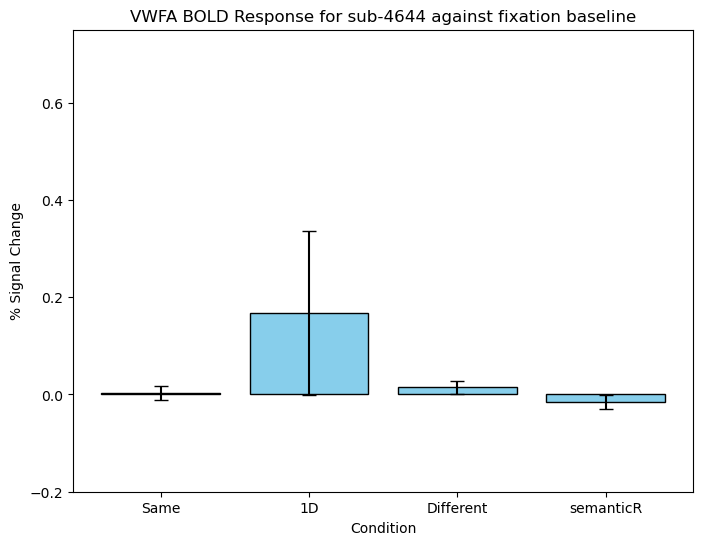

In [43]:
# Extracting values for plotting
bar_heights_4644 = new_result_matrix_4644[:, 1]
error_values_4644 = new_result_matrix_4644[:, 2]

# Plotting the bar graph with error bars
plt.figure(figsize=(8, 6))
plt.bar(new_column_names, bar_heights_4644, yerr=error_values_4644, capsize=5, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Condition')
plt.ylabel('% Signal Change')
plt.title('VWFA BOLD Response for sub-4644 against fixation baseline')
plt.ylim(-0.2, 0.75)

# Showing the plot
plt.show()